# General Data Processing

In this Notebook I use the data from Quantum Espresso to visualize various things.

This notebook serves the purpose of testing all the written functions, that don't fit in any other notebook.

In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True, legacy="1.21")

from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import symmetry
from tight_binding_redweasel import fermi_surface as fs
from tight_binding_redweasel import density_of_states as dos
from tight_binding_redweasel import bulk_properties as bulk

9261 9261


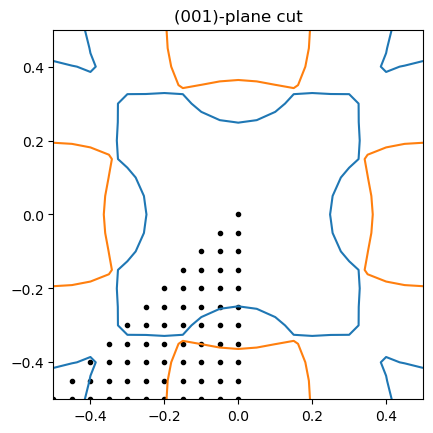

In [2]:
importlib.reload(symmetry)

# correct 2d fermi surface cuts from ./tmp/nitinol_0K.xml

material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, weights, bands, symmetries, fermi_energy = material.read_bands()

select = k_smpl[:,0] == 0
#plt.plot(k_smpl[select,1], k_smpl[select,2], "k.")

sym_count = len(k_smpl)
sym = symmetry.Symmetry(symmetries)
k_smpl, bands = sym.realize_symmetric_data(k_smpl, bands)

dim = 3
print(len(k_smpl), 21**3)
n = round(len(k_smpl)**(1/dim))
assert n**dim == len(k_smpl)
# this reduced data is actually cleaner than the version from quantum espresso
reduced_k = sym.reduce_symmetric_data(k_smpl, bands)[0]
assert sym_count == len(reduced_k)

select = reduced_k[:,0] == 0
plt.plot(reduced_k[select,1], reduced_k[select,2], "k.")

select = k_smpl[:,0] == 0
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select] % (21 * 21))
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select] % 21)
#plt.scatter(k_smpl[select,1], k_smpl[select,2], 10.0, c=np.arange(len(k_smpl))[select])
#plt.colorbar()
for band_index in range(len(bands[0])):
    xy = k_smpl[select,1:]
    z = bands[select, band_index] - fermi_energy
    if not (np.any(z > 0) and np.any(z < 0)):
        continue
    
    #plt.tricontour(xy[:,0], xy[:,1], z, levels=(0.,), colors=f"C{band_index-14}")
    # because it is well sorted one can actually do this:
    plt.contour(xy[:,0].reshape((21, 21)), xy[:,1].reshape((21, 21)), z.reshape((21, 21)), levels=(0.,), colors=f"C{band_index-14}")

plt.gca().set_aspect("equal")
plt.title("(001)-plane cut")
plt.show()

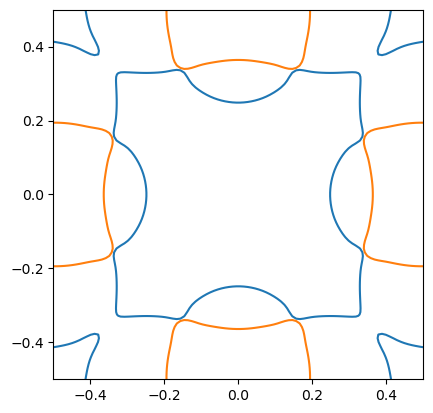

In [3]:
# trilinear/tricubic interpolation
import scipy.interpolate as interp

select = k_smpl[:,0] == 0
used_k_smpl = k_smpl[select,1:].reshape((21, 21, 2)).swapaxes(0, 2)#.swapaxes(1, 2)
#print(used_k_smpl[1])
interpolator = interp.RegularGridInterpolator((used_k_smpl[0][:,0], used_k_smpl[1][0,:]),
                                              bands[select].reshape((21, 21, -1)),
                                              method="cubic")
lin = np.linspace(-0.5, 0.5, 100)
x, y = np.meshgrid(lin, lin)
xy = np.stack((x, y), axis=-1)
z_unshifted = interpolator(xy)

for band_index in range(len(bands[0])):
    z = z_unshifted[:,:,band_index] - fermi_energy
    if not (np.any(z > 0) and np.any(z < 0)):
        continue
    plt.contour(xy[:,:,0], xy[:,:,1], z, levels=(0.,), colors=f"C{band_index-14}")
plt.gca().set_aspect("equal")
plt.show()

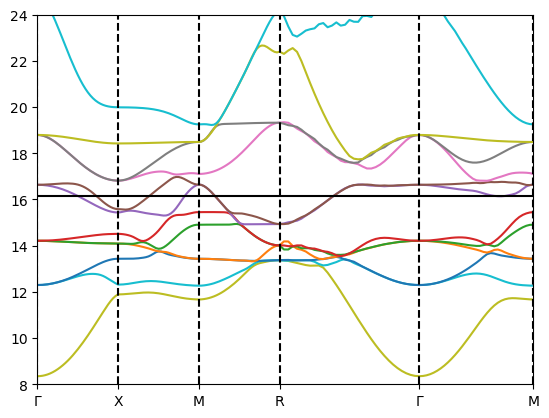

In [4]:
from tight_binding_redweasel import kpaths
importlib.reload(kpaths)

# trilinear/tricubic interpolation
import scipy.interpolate as interp

used_k_smpl = k_smpl.reshape((21, 21, 21, 3)).T
#print(used_k_smpl[2])
interpolator = interp.RegularGridInterpolator((used_k_smpl[0][:,0,0], used_k_smpl[1][0,:,0], used_k_smpl[2][0,0,:]),
                                              bands.reshape((21, 21, 21, -1)),
                                              method="cubic")

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
#print(np.array(path))
ibands = interpolator(np.array(path)/2) # different units here...
x_smpl = path.x()
for i in range(len(ibands[0])):
    plt.plot(x_smpl, ibands[:,i])
for sym_x in path.sym_x():
    plt.axvline(sym_x, color="k", linestyle="dashed")
plt.xticks(path.sym_x(), path.sym_x_names())
plt.xlim(np.min(x_smpl), np.max(x_smpl))
plt.axhline(fermi_energy, color='k')
plt.ylim(8, 24)
plt.show()

Now do the same using the `kpaths` API

Electrons per Unit-Cell: 15
Naive Fermi Energy: 16.162355990940373
QE  Fermi Energy: 16.157399621460513
DOS Fermi Energy: 16.18175745335538


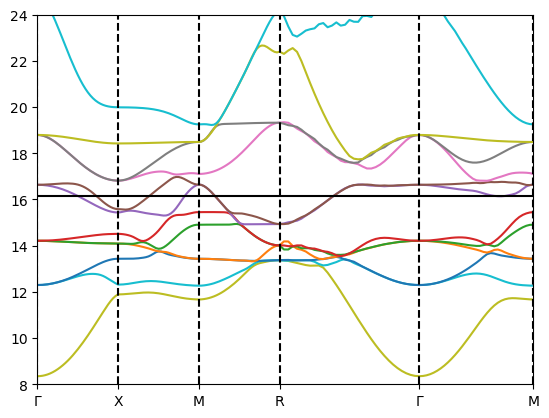

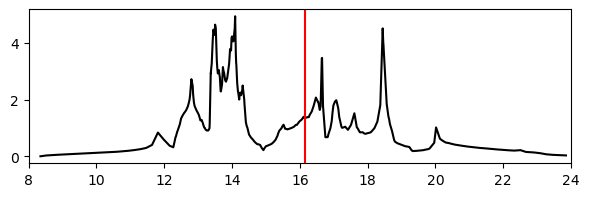

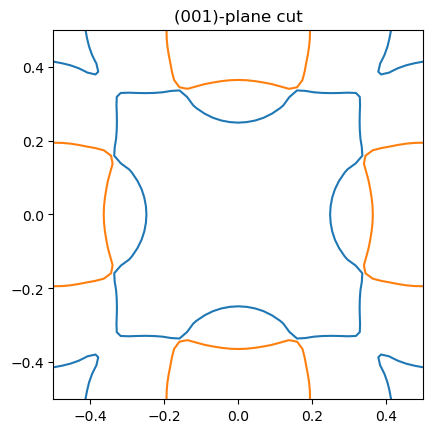

In [5]:
from tight_binding_redweasel import kpaths
importlib.reload(kpaths)
from tight_binding_redweasel import fermi_surface
importlib.reload(fermi_surface)
from tight_binding_redweasel import density_of_states as dos
importlib.reload(dos)

material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, weights, bands, symmetries, fermi_energy = material.read_bands()

sym = symmetry.Symmetry(symmetries)
interpolator = kpaths.interpolate(k_smpl, bands, sym, method='cubic')

path = kpaths.KPath('G').to('X').to('M').to('R').to('G').to('M')
path.plot(interpolator)
plt.axhline(fermi_energy, color='k')
plt.ylim(8, 24)

# TODO add this plot sideways to the top plot
dos_model = dos.DensityOfStates(interpolator, N=10, ranges=((0.0, 0.5),)*3, wrap=False)
neutral_electrons = round(dos_model.states_below(fermi_energy))
print("Electrons per Unit-Cell:", neutral_electrons)
print("Naive Fermi Energy:", dos.naive_fermi_energy(bands, neutral_electrons))
print("QE  Fermi Energy:", fermi_energy)
print("DOS Fermi Energy:", dos_model.fermi_energy(neutral_electrons))
plt.show()

energy_smpl, states, density = dos_model.full_curve(N=30)
select = (energy_smpl > 8) & (energy_smpl < 24)
plt.figure(figsize=(7, 2))
plt.plot(energy_smpl[select], density[select], 'k-')
plt.axvline(fermi_energy, color='r')
plt.xlim(8, 24)
plt.show()

fermi_surface.plot_2D_fermi_surface(interpolator, fermi_energy, z=[0.0], N=45)

# Testing Bulk Properties

In [8]:
from tight_binding_redweasel.bandstructure import *
# read the data from Bandx.dat from Quantum Espresso
from tight_binding_redweasel import qespresso_interface as qe
material = qe.QECrystal("nitinol_0K", [], [], [], 0)
k_smpl, ref_bands = material.read_bandx_raw()
all_ref_bands = ref_bands
ref_bands = ref_bands[:,8:]
neutral_electrons = 7

tb_nitinol = BandStructureModel.load("asym_nitinol4.json")
tb_nitinol.optimize(k_smpl, 1, ref_bands, 1, 0, 0, 1)

preparing pseudoinverse
maximal acceleration 1.0
final loss: 6.84e-02 (max band-error [0.052 0.041 0.021 0.059 0.069 0.056 0.067 0.05  0.079 0.064 0.118 0.099])


In [90]:
from tight_binding_redweasel import bulk_properties as bulk
importlib.reload(bulk)
importlib.reload(dos)
from tight_binding_redweasel import symmetry
importlib.reload(symmetry)

T = 300
model = tb_nitinol
electrons = neutral_electrons

dos_model = dos.DensityOfStates(model, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
mu = dos_model.chemical_potential(electrons, [T], N=40)
print("chemical potential:", *mu)

chemical potential: 16.17922168816893


In [91]:
print(dos.naive_energy(dos_model.bands, 300, mu))
dos_model.energy(300.0, electrons, mu)

95.77402761201591


-2575.4856894996215

In [55]:
dos_model.heat_capacity(1, mu)

0.0

In [ ]:
sigma_over_tau = bulk.conductivity_over_tau(dos_model, electrons, 2.993e-10, T=T, mu=mu, print_error=True)
sym = symmetry.Symmetry.from_generator([np.eye(3), ((1,0,0), (0,0,1), (0,-1,0))], True)
sigma_over_tau = sym.symmetrize(sigma_over_tau)
mean_sigma = np.trace(sigma_over_tau)/3
print(sigma_over_tau / mean_sigma)
print("conductivity", mean_sigma, "× τ")

# without symmetry:
#dos_model = dos.DensityOfStates(model, N=24, ranges=((-0.5, 0.5),)*3, wrap=False)
#sigma_over_tau = bulk.conductivity_over_tau(dos_model, electrons, 2.993e-10, T=T, mu=mu)
#mean_sigma = np.trace(sigma_over_tau)/3
#print(sigma_over_tau / mean_sigma)
#print("conductivity", mean_sigma, "× τ")

In [22]:
from tight_binding_redweasel import bulk_properties as bulk
importlib.reload(bulk)
sigma_over_tau = bulk.conductivity_over_tau2(dos_model, electrons, 2.993e-10, T=T, mu=mu, print_error=True)
#sym = symmetry.Symmetry.from_generator([np.eye(3), ((1,0,0), (0,0,1), (0,-1,0))], True)
#sigma_over_tau = sym.symmetrize(sigma_over_tau)
mean_sigma = np.trace(sigma_over_tau)/3
print(sigma_over_tau / mean_sigma)
print("conductivity", mean_sigma, "× τ")

error: 0.009248%
[[1.003 0.127 0.155]
 [0.127 0.993 0.133]
 [0.155 0.133 1.004]]
conductivity 1.1027005880567041e+22 × τ


In [37]:
from tight_binding_redweasel import bulk_properties as bulk
importlib.reload(bulk)
k_integral = bulk.KIntegral(dos_model, electrons, T=T, errors=True)

In [38]:
sigma_over_tau = k_integral.conductivity_over_tau(2.993e-10, print_error=True)
mean_sigma = np.trace(sigma_over_tau)/3
print(sigma_over_tau / mean_sigma)
print("conductivity", mean_sigma, "× τ")

heat_capacity = k_integral.heat_capacity(2.993e-10, print_error=True)
print("heat_capacity", heat_capacity, "J/m^3/K")
print("literature:", 5.401e6, "J/m^3/K") # 0.20 cal/g*deg * 6.45 g/cm^3 from https://matthey.com/products-and-markets/other-markets/medical-components/resource-library/nitinol-technical-properties

error: 0.009249%
[[1.003 0.127 0.155]
 [0.127 0.993 0.133]
 [0.155 0.133 1.004]]
conductivity 6.891876934484756e+20 × τ
error: 43.946952%
heat_capacity 9.125308177052825e-24 J/m^3/K
literature: 5401000.0 J/m^3/K


12.775695428643125
12.440716451338417
11.677963010206684
11.140688686924845
10.832978047345092
10.231031454272303
7.862600084327311


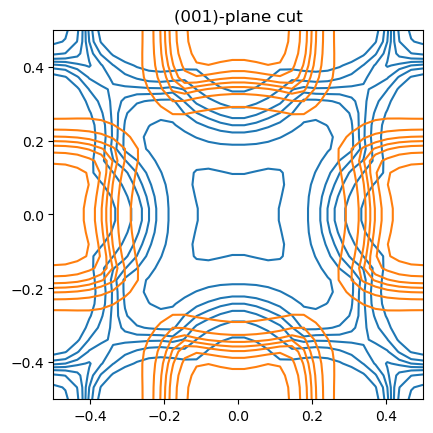

In [14]:
from tight_binding_redweasel import fermi_surface
importlib.reload(fermi_surface)

T = 300
model = tb_nitinol
electrons = neutral_electrons
#model = linear
#electrons = 2

beta = 1 / (dos.k_B * T) # in 1/eV
dos_model = dos.DensityOfStates(model, N=24, ranges=((0.0, 0.5),)*3, wrap=False)
mu = dos_model.chemical_potential(electrons, [T], N=40)
def dfermi(x):
    return -0.25 / np.cosh(0.5 * x)**2
def plot_fermi_surface(e_smpl):
    for e in e_smpl:
        fermi_surface.plot_2D_fermi_surface(model, e, z=[0.0], N=32, show=False)
        k_smpl, indices, weights, _ = dos_model.fermi_surface_samples(e, improved_points=True, normalize=None)
        _, v = dos_model.model.bands_grad(k_smpl)
        v = np.take_along_axis(v, indices.reshape(-1, 1, 1), axis=-1)[:,:,0]
        print(np.trace(np.einsum("ia,ib,i->ab", v, v, weights/(1e-8 + np.linalg.norm(v, axis=-1))))/3)
    return e_smpl
dos.gauss_7_df(plot_fermi_surface, mu, beta)
plt.show()

# Hall Coefficient

[[-1.807  0.    -1.807]
 [ 0.     1.807  1.807]
 [ 1.807  1.807  0.   ]]
density 8.94 g/cm³
Symmetries: 48
[[ 0.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0. -1.]
 [ 0.  0.  1.]
 [ 1. -1.  0.]
 [ 0. -1.  1.]
 [ 0. -1.  0.]
 [ 1. -1.  1.]
 [ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -2.  0.]
 [ 1. -2.  1.]
 [ 0. -1.  2.]
 [-1.  0.  2.]
 [ 2. -1. -1.]
 [ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 0.  1.  1.]
 [ 2.  0. -1.]
 [-1. -1.  2.]
 [ 2. -1.  0.]
 [ 0. -2.  1.]]


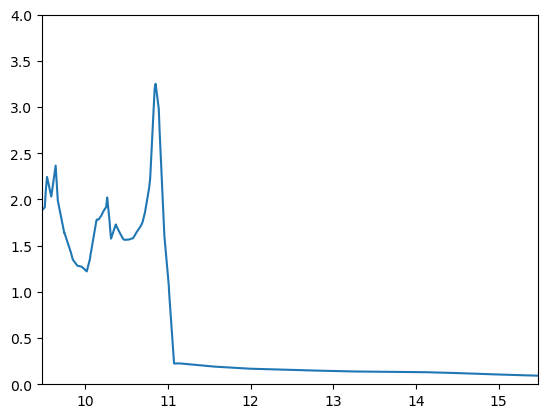

5.5 5.4947036050782145
0.15552896943943623
12.50641876530273 12.472232899089112


/media/Daten/userfiles/Dokumente/Studium/Semester9/Masterarbeit/code/library/notebooks/../src/tight_binding_redweasel/density_of_states.py:166: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(beta*e)) # overflows can be safely ignored here!


In [1]:
import setup
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, suppress=True, legacy="1.21")

from tight_binding_redweasel import qespresso_interface as qe
from tight_binding_redweasel import symmetry
from tight_binding_redweasel import bandstructure
from tight_binding_redweasel import fermi_surface as fs
from tight_binding_redweasel import density_of_states as dos
from tight_binding_redweasel import bulk_properties as bulk

#material = qe.QECrystal("nitinol_2_993", [], [], [], 0)
#cell_length = 2.993
#A = np.eye(3) * cell_length

material = qe.QECrystal("cu", [], [(0,0,0)], ["Cu"], 0)
k_smpl, ref_bands, symmetries, fermi_energy, A = material.read_bands_crystal()
material.A = A
# use the cubic cell for testing against the correct cell
#A = np.eye(3) * abs(A[0,0]) * 2

print(A)
print(f"density {material.mass_density()*1e-3:.2f} g/cm³")
print("Symmetries:", len(symmetries))

#ref_bands = ref_bands[:,8:]
#k_smpl, ref_bands = symmetry.Symmetry(symmetries).realize_symmetric_data(k_smpl, ref_bands)
#tb_model = bandstructure.BandStructureModel.load("asym_nitinol5.json")
tb_model = bandstructure.BandStructureModel.load("cu_asym_3.json")
B = np.linalg.inv(A).T

T = 300
electrons = 5.5
beta = 1 / (dos.k_B * T) # in 1/eV
spin_factor = 2

tb_model.transform(B.T / B[0,0])
#tb_model.transform(np.eye(3) * 2)
dos_model = dos.DensityOfStates(tb_model, N=28)
#dos_model = dos.DensityOfStates(tb_model, N=32, ranges=((-1,1),)*3)
print(tb_model.neighbors)

e_smpl, _, rho_smpl = dos_model.full_curve(N=20) # TODO test with temperature
plt.plot(e_smpl, rho_smpl)
plt.xlim(fermi_energy - 3, fermi_energy + 3)
plt.ylim(0, 4)
plt.show()

print(electrons, dos_model.states_below(fermi_energy))
print(dos_model.density(fermi_energy))
print(dos_model.fermi_energy(electrons), fermi_energy)

kint = bulk.KIntegral(dos_model, electrons, T, errors=False)

In [2]:
cell_length = np.linalg.norm(A[:,0])
#sigma_xyz = bulk.elementary_charge**3/bulk.c/bulk.eV * kint.integrate_df_A(A, lambda _e, v, h, _k: (v[:,0]**2*h[:,1,1] - v[:,0]*v[:,1]*h[:,1,0]), hessians=True)
sigma_xyz = 2 * bulk.elementary_charge**3/bulk.eV * kint.integrate_df_A(A, lambda _e, v, h, _k: (v[:,0]**2*h[:,1,1] - v[:,0]*v[:,1]*h[:,1,0]), hessians=True)[0]
sigma_xx = 2 * bulk.elementary_charge**2/bulk.eV * kint.integrate_df_A(A, lambda _e, v, _k: v[:,0]**2, hessians=False)[0]
# The pi factor here makes it of a wrong order of magnitude...
R_H = sigma_xyz / sigma_xx**2 * (cell_length*1e-10/(2*np.pi))**3 # in m^3/C = Ohm m/T
print(R_H)

2.4351738361063035e-13


In [11]:
# naive Hall Constant using n valence electrons per cell
n = 1.0
print(1e12 * -1 / n * np.linalg.det(A*1e-10)/bulk.elementary_charge)

-73.70253633343972


In [4]:
# https://de.wikipedia.org/wiki/Hall-Konstante
# should be (all vary strongly with purity)
# Cu   -53e-12 m^3/C
# Li  -170e-12 m^3/C
# Al    99e-12 m^3/C  or  -34e-12 m^3/C ???
kint.hall_coefficient(A, 2)[0] * 1e12

42.712459128301795

In [5]:
R_H, error = kint.hall_coefficient_metal_cubic(A, 2)
print(f"{R_H*1e12}±{error*1e12}")

-43.04298356555617±-0.0


In [8]:
# The tensor version returns two things
(sigma2, sigma2_err), (sigma3, sigma3_err) = kint.conductivity_hall_tensor(A, 2)
#print(sigma2 / np.linalg.norm(sigma2)) # very strongly non symmetric... hmm
#print(sigma3 / np.linalg.norm(sigma3))
sigma_0 = np.trace(sigma2) / 3
sigma_H = np.sum(sigma3 * bulk.antisym_tensor) / 6
print(sigma_0 * 1e-21) # cu = 1.61, correct: 1.4
print(sigma_H * 1e-30) # cu = -421, correct: -114
#print(sigma_H, sigma3[0,1,2]) # works!
print(sigma_H / sigma_0**2 * 1e12)

1.4521880671934593
-90.7712037475278
-43.04298356555616


In [9]:
cell_length = A[0,0]*2 # fcc
print(kint.drude_factor(A, 2)[0] * 1e-20)
print(kint.conductivity_over_tau(cell_length*1e-10, 2) * 1e-20)

[[14.543  1.451  1.298]
 [ 1.451 14.527 -1.287]
 [ 1.298 -1.287 14.496]]
[[-11.611   4.369   4.264]
 [  4.369 -11.622   4.277]
 [  4.264   4.277 -11.459]]
